In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('15mindata.csv')


In [3]:
data.head()

,DateTimeLogged,Area,TripDistance,duration,TotalFare,speed
0,2021-01-01 00:00:00,3,89921,2.166944,237.0,41496.679913
1,2021-01-01 00:15:00,3,47035,1.336667,148.5,35188.279302
2,2021-01-01 00:30:00,3,86311,2.924167,258.5,29516.443431
3,2021-01-01 00:45:00,3,71443,2.185000,210.0,32697.025172
4,2021-01-01 01:00:00,3,29960,0.865556,94.0,34613.607189


In [4]:
format="%Y-%m-%d %H:%M:%S"
data['DateTimeLogged'] = pd.to_datetime(data['DateTimeLogged'],format=format)
data = data.set_index(pd.DatetimeIndex(data['DateTimeLogged']))
data = data.drop(['DateTimeLogged'], axis=1)

In [5]:
data.shape

(259196, 5)

In [6]:
# the following areas are the busiest places sorted by availability of trips every 17 minutes
selected_locations=[ 78,  55,  57,  28,  83,   5, 118,  77,  41,  11, 114,   8, 115,
             84,  82, 116,   9,  27,   4,  17,  42,  85,  33,   7,  86,  73,
            103,  46, 102,   3, 112, 107, 111,  14,  36,  12,  71]

In [7]:
series_by_loc_dict = {loca:data.query(f"Area == {loca}") for loca in selected_locations}

In [8]:
series_by_loc_dict[82].head()

,Area,TripDistance,duration,TotalFare,speed
DateTimeLogged,,,,,
2021-01-01 00:00:00,82,630998,20.655833,1620.51,30548.174446
2021-01-01 00:15:00,82,1275255,40.930833,3263.54,31156.340982
2021-01-01 00:30:00,82,855844,22.181667,2093.50,38583.394695
2021-01-01 00:45:00,82,896610,25.056389,2290.03,35783.687904
2021-01-01 01:00:00,82,1050856,23.964167,2505.00,43851.138853


In [9]:
import copy

df_by_loc={}

for loc in selected_locations:
    key_name='loc_df_'+str(loc)
    df_by_loc[key_name]=copy.deepcopy(series_by_loc_dict[loc])
    

In [10]:

train_by_loc={}
test_by_loc={}

for loc in selected_locations:
    key_name_train='train_'+str(loc)
    key_name_test='test'+str(loc)
    train_by_loc[key_name_train]=copy.deepcopy(df_by_loc[f'loc_df_{loc}']["2021-01":"2021-03-20"].TotalFare)
    test_by_loc[key_name_test]=copy.deepcopy(df_by_loc[f'loc_df_{loc}']["2021-03-21":"2021-03-31"].TotalFare)



In [11]:
loc82_dfl = data.query("Area == 82").drop("Area", axis=1)
loc111_dfl = data.query("Area == 111").drop("Area", axis=1)
loc116_dfl = data.query("Area == 116").drop("Area", axis=1)
loc11_dfl = data.query("Area == 11").drop("Area", axis=1)


In [12]:
%%time
train_82 = loc82_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_82 = loc82_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

train_111 = loc111_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_111 = loc111_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

train_116 = loc116_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_116 = loc116_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

train_11 = loc11_dfl["2021-01":"2021-03-20"].iloc[:, [0,1,2,3]]
test_11 = loc11_dfl["2021-03-21":"2021-03-31"].iloc[:, [0,1,2,3]]

Wall time: 15.6 ms


# Baseline method

In [13]:
# baseline prediction for location 82
fares_82_train=pd.DataFrame(train_by_loc['train_82'].values)
fares_82_test=pd.DataFrame(test_by_loc['test82'].values)
# Create lagged dataset
dataframe_train_82 = pd.concat([fares_82_train.shift(1), fares_82_train], axis=1)
dataframe_train_82.columns = ['t-1', 't+1']
print(dataframe_train_82.head(5))
dataframe_test_82=pd.concat([fares_82_test.shift(1), fares_82_test], axis=1)
dataframe_test_82.columns = ['t-1', 't+1']
print(dataframe_test_82.head(5))
# train and test labels
dataframe_train_X_82, dataframe_train_Y_82 = dataframe_train_82.values[:,0], dataframe_train_82.values[:,1]
dataframe_test_X_82, dataframe_test_Y_82 = dataframe_test_82.values[1:,0], dataframe_test_82.values[1:,1]

       t-1      t+1
0      NaN  1620.51
1  1620.51  3263.54
2  3263.54  2093.50
3  2093.50  2290.03
4  2290.03  2505.00
       t-1      t+1
0      NaN   970.51
1   970.51   855.51
2   855.51   783.52
3   783.52  1115.50
4  1115.50  1049.50


In [14]:
# persistence model
#here the model returns the current values as a predicted future value
def model_persistence(x):
    return x

# walk-forward validation
predictions_82 = list()
for fare in dataframe_test_X_82:
    yhat_82 = model_persistence(fare)
    predictions_82.append(yhat_82)
test_score_82 = sqrt(mean_squared_error(dataframe_test_Y_82, predictions_82))
print('Test RMSE: %.3f' % test_score_82)

Test RMSE: 327.260


In [15]:
# baseline prediction for location 82
fares_116_train=pd.DataFrame(train_by_loc['train_116'].values)
fares_116_test=pd.DataFrame(test_by_loc['test116'].values)
# Create lagged dataset
dataframe_train_116 = pd.concat([fares_116_train.shift(1), fares_116_train], axis=1)
dataframe_train_116.columns = ['t-1', 't+1']
print(dataframe_train_116.head(5))
dataframe_test_116=pd.concat([fares_116_test.shift(1), fares_116_test], axis=1)
dataframe_test_116.columns = ['t-1', 't+1']
print(dataframe_test_116.head(5))
# train and test labels
dataframe_train_X_116, dataframe_train_Y_116 = dataframe_train_116.values[:,0], dataframe_train_116.values[:,1]
dataframe_test_X_116, dataframe_test_Y_116 = dataframe_test_116.values[1:,0], dataframe_test_116.values[1:,1]

       t-1      t+1
0      NaN  2376.00
1  2376.00  2799.26
2  2799.26  2665.51
3  2665.51  2729.01
4  2729.01  2610.52
      t-1     t+1
0     NaN  825.51
1  825.51  892.00
2  892.00  981.51
3  981.51  990.02
4  990.02  966.01


In [16]:
# walk-forward validation
predictions_116 = list()
for fare in dataframe_test_X_116:
    yhat_116 = model_persistence(fare)
    predictions_116.append(yhat_116)
test_score_116 = sqrt(mean_squared_error(dataframe_test_Y_116, predictions_116))
print('Test RMSE: %.3f' % test_score_116)

Test RMSE: 331.791


In [17]:
# baseline prediction for location 82
fares_111_train=pd.DataFrame(train_by_loc['train_111'].values)
fares_111_test=pd.DataFrame(test_by_loc['test111'].values)
# Create lagged dataset
dataframe_train_111 = pd.concat([fares_111_train.shift(1), fares_111_train], axis=1)
dataframe_train_111.columns = ['t-1', 't+1']
print(dataframe_train_111.head(5))
dataframe_test_111=pd.concat([fares_111_test.shift(1), fares_111_test], axis=1)
dataframe_test_111.columns = ['t-1', 't+1']
print(dataframe_test_111.head(5))
# train and test labels
dataframe_train_X_111, dataframe_train_Y_111 = dataframe_train_111.values[:,0], dataframe_train_111.values[:,1]
dataframe_test_X_111, dataframe_test_Y_111 = dataframe_test_111.values[1:,0], dataframe_test_111.values[1:,1]

      t-1     t+1
0     NaN  161.50
1  161.50  234.01
2  234.01  302.00
3  302.00  354.50
4  354.50  480.00
      t-1     t+1
0     NaN  169.00
1  169.00  283.00
2  283.00  266.55
3  266.55  233.00
4  233.00  209.00


In [18]:
# walk-forward validation
predictions_111 = list()
for fare in dataframe_test_X_111:
    yhat_111= model_persistence(fare)
    predictions_111.append(yhat_111)
test_score_111 = sqrt(mean_squared_error(dataframe_test_Y_111, predictions_111))
print('Test RMSE: %.3f' % test_score_111)

Test RMSE: 198.758


In [19]:
# baseline prediction for location 82
fares_11_train=pd.DataFrame(train_by_loc['train_11'].values)
fares_11_test=pd.DataFrame(test_by_loc['test11'].values)
# Create lagged dataset
dataframe_train_11 = pd.concat([fares_11_train.shift(1), fares_11_train], axis=1)
dataframe_train_11.columns = ['t-1', 't+1']
print(dataframe_train_11.head(5))
dataframe_test_11=pd.concat([fares_11_test.shift(1), fares_11_test], axis=1)
dataframe_test_11.columns = ['t-1', 't+1']
print(dataframe_test_11.head(5))
# train and test labels
dataframe_train_X_11, dataframe_train_Y_11 = dataframe_train_11.values[:,0], dataframe_train_11.values[:,1]
dataframe_test_X_11, dataframe_test_Y_11 = dataframe_test_11.values[1:,0], dataframe_test_11.values[1:,1]

     t-1    t+1
0    NaN  504.5
1  504.5  424.0
2  424.0  331.5
3  331.5  550.5
4  550.5  814.0
      t-1     t+1
0     NaN  449.51
1  449.51  439.51
2  439.51  245.00
3  245.00  178.00
4  178.00  164.50


In [20]:
# walk-forward validation
predictions_11 = list()
for fare in dataframe_test_X_11:
    yhat_11= model_persistence(fare)
    predictions_11.append(yhat_11)
test_score_11 = sqrt(mean_squared_error(dataframe_test_Y_11, predictions_11))
print('Test RMSE: %.3f' % test_score_11)

Test RMSE: 153.466


# Markov Chain

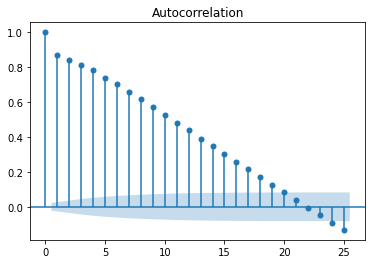

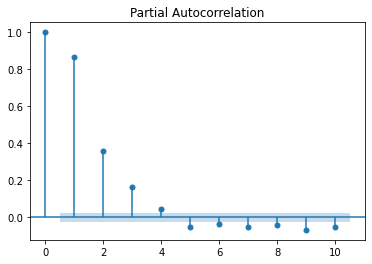

In [21]:
plot_acf(train_by_loc['train_82'], lags=25)
plot_pacf(train_by_loc['train_82'], lags=10)
plt.show()

In [22]:
temp_82 = sm.tsa.stattools.pacf(train_by_loc['train_82'])
print(temp_82)
weights_82 = np.zeros(4)
for i in range(4):
    weights_82[i] = temp_82[i+1]
weights_82 = weights_82/weights_82.sum()
print(weights_82)

[ 1.          0.86793003  0.35838011  0.16171979  0.04350801 -0.05239843
 -0.03445583 -0.04964694 -0.04193935 -0.06737804 -0.04973525 -0.0343651
 -0.02171066 -0.05138788 -0.01553611 -0.01659532 -0.0295347  -0.0334488
 -0.03150013 -0.05417144 -0.04219205 -0.04261361 -0.04218474 -0.03143366
 -0.06020701 -0.03444412 -0.02929328 -0.01115261 -0.0239003  -0.00359538
  0.01104303  0.0098884  -0.0030585  -0.01760105  0.01793045 -0.02019839
 -0.01957538 -0.0229094  -0.01065464 -0.02786913 -0.08660744]
[0.60629202 0.25034622 0.11296927 0.03039249]


C:\Users\Zhaks\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1016: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


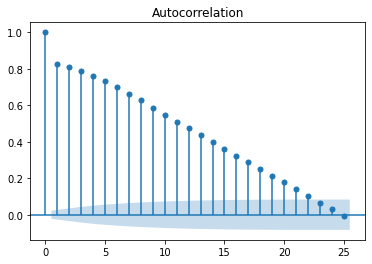

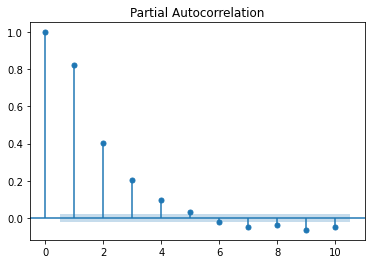

In [23]:
plot_acf(train_by_loc['train_116'], lags=25)
plot_pacf(train_by_loc['train_116'], lags=10)
plt.show()

In [24]:
temp_116 = sm.tsa.stattools.pacf(train_by_loc['train_116'])
print(temp_116)
weights_116 = np.zeros(5)
for i in range(5):
    weights_116[i] = temp_116[i+1]
weights_116 = weights_116/weights_116.sum()
print(weights_116)

[ 1.00000000e+00  8.25502893e-01  4.02879973e-01  2.02334164e-01
  9.61497409e-02  2.96699782e-02 -2.43825651e-02 -5.02560550e-02
 -3.95173569e-02 -6.48899445e-02 -5.13483604e-02 -5.23929494e-02
 -4.23400234e-03 -2.27734279e-02 -2.69212267e-02 -4.06833326e-02
 -1.95927887e-02 -1.75639378e-02 -3.11282871e-02 -3.30656669e-02
 -7.93362125e-03 -4.29061364e-02 -3.62078209e-02 -4.96632434e-02
 -3.49105687e-02 -4.34413725e-02 -4.34372117e-02 -4.15210725e-02
 -5.97105245e-03 -4.01551754e-03  7.48956109e-03 -7.86297071e-03
 -6.01910858e-03  2.45421019e-02  2.08762885e-02  9.81030702e-03
  6.10563768e-04  5.20626168e-03  2.23658253e-03 -2.80510466e-02
 -1.61492782e-02]
[0.53034591 0.25883101 0.12998997 0.06177158 0.01906153]


C:\Users\Zhaks\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1016: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


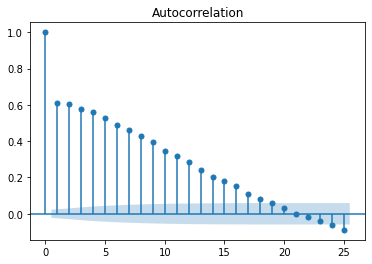

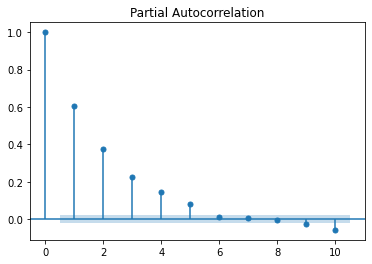

In [25]:
plot_acf(train_by_loc['train_111'], lags=25)
plot_pacf(train_by_loc['train_111'], lags=10)
plt.show()

In [26]:
temp_111 = sm.tsa.stattools.pacf(train_by_loc['train_111'])
print(temp_111)
weights_111 = np.zeros(5)
for i in range(5):
    weights_111[i] = temp_111[i+1]
weights_111 = weights_111/weights_111.sum()
print(weights_111)

[ 1.00000000e+00  6.08001797e-01  3.73583937e-01  2.25751332e-01
  1.47539825e-01  7.95422040e-02  1.20081680e-02  3.71341771e-03
 -5.71974389e-03 -2.39992762e-02 -5.74657147e-02 -3.92417828e-02
 -2.33704757e-02 -5.15945372e-02 -4.75391939e-02 -1.59682520e-02
 -1.33267748e-02 -4.17034320e-02 -2.55846206e-02 -4.42995649e-03
 -2.29971321e-02 -2.62425256e-02 -8.09168009e-03 -1.33371222e-02
 -1.95724051e-02 -2.97480638e-02 -2.39567928e-02 -3.33882554e-02
 -2.20894706e-02 -3.45292457e-02 -4.81500426e-02 -3.67394982e-02
 -4.13815294e-02 -3.55699932e-03  7.24675452e-04  5.97041768e-03
 -8.18963473e-03 -2.41989568e-02 -1.31570220e-02 -6.01009433e-03
 -6.23730297e-03]
[0.42386622 0.26044267 0.15738171 0.10285685 0.05545256]


C:\Users\Zhaks\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1016: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


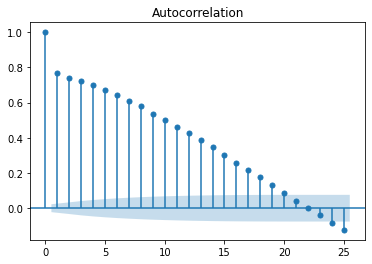

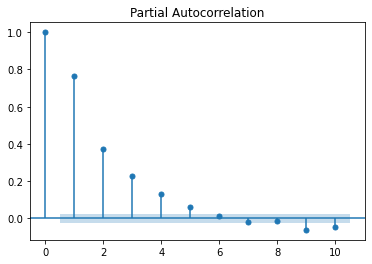

In [27]:
plot_acf(train_by_loc['train_11'], lags=25)
plot_pacf(train_by_loc['train_11'], lags=10)
plt.show()

In [28]:
temp_11 = sm.tsa.stattools.pacf(train_by_loc['train_11'])
print(temp_11)
weights_11 = np.zeros(5)
for i in range(5):
    weights_11[i] = temp_11[i+1]
weights_11 = weights_11/weights_11.sum()
print(weights_11)

[ 1.          0.76604215  0.37184539  0.2278324   0.13074178  0.06052596
  0.0146651  -0.02142948 -0.01614075 -0.06141954 -0.04825438 -0.04969427
 -0.03150523 -0.04390488 -0.04311053 -0.0674487  -0.05958078 -0.04642961
 -0.04881165 -0.05005611 -0.04973009 -0.05918461 -0.03539606 -0.02023347
 -0.05449477 -0.04050633 -0.05700267 -0.03276286 -0.03590706 -0.01872167
 -0.01996001 -0.00910858 -0.02106273  0.00449702  0.01129787  0.01428116
 -0.01932755 -0.02737238 -0.00248605 -0.03489917 -0.03536026]
[0.4920027  0.23882359 0.14632897 0.08397098 0.03887376]


C:\Users\Zhaks\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1016: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


In [29]:
# depending on the min and max values we will create states
print(train_by_loc['train_82'].values.max())
print(train_by_loc['train_116'].values.max())
print(train_by_loc['train_111'].values.max())
print(train_by_loc['train_11'].values.max())

print(train_by_loc['train_82'].values.min())
print(train_by_loc['train_116'].values.min())
print(train_by_loc['train_111'].values.min())
print(train_by_loc['train_11'].values.min())

4016.01
3637.02
1240.01
1465.0
0.0
0.0
0.0
0.0


In [30]:
print(train_by_loc['train_82'].where(train_by_loc['train_82'].gt(0)).min(0))
print(train_by_loc['train_116'].where(train_by_loc['train_116'].gt(0)).min(0))
print(train_by_loc['train_111'].where(train_by_loc['train_111'].gt(0)).min(0))
print(train_by_loc['train_11'].where(train_by_loc['train_11'].gt(0)).min(0))

10.0
10.0
8.0
7.0


In [31]:
len(train_by_loc['train_82'])

7584

### Creating different states for Demand such as:
#### values ----- states

0----------------0

12 to 100-------1

101 to 201-------2

202 to 302-------3

303 to 403-------4

404 to 504-------5

505 to 605-------6

and so on

**minmum value of TotalFare is 12 and if there's no demand then it is 0.

In [32]:
# arr_train_82 = np.zeros(7584)
# j=0
# for (i,j) in zip (train_by_loc['train_82'],range(7584)):
#     if (i>=7 and i<=207):
#         arr_train_82[j]=1
#     elif(i>=208 and i<=408):
#         arr_train_82[j]=2
#     elif(i>=409 and i<=609):
#         arr_train_82[j]=3
#     elif(i>=610 and i<=809):
#         arr_train_82[j]=4
#     elif(i>=810 and i<=1010):
#         arr_train_82[j]=5
#     elif(i>=1011 and i<1211):
#         arr_train_82[j]=6
#     elif(i>=1212 and i<=1412):
#         arr_train_82[j]=7
#     elif(i>=1413 and i<=1613):
#         arr_train_82[j]=8
#     elif(i>=1614 and i<1814):
#         arr_train_82[j]=9
#     elif(i>=1815 and i<=2015):
#         arr_train_82[j]=10
#     elif(i>=2016 and i<=2216):
#         arr_train_82[j]=11
#     elif(i>=2217 and i<=2417):
#         arr_train_82[j]=12
#     elif(i>=2418 and i<=2618):
#         arr_train_82[j]=13
#     elif(i>=2619 and i<=2819):
#         arr_train_82[j]=14
#     elif(i>=2820 and i<3020):
#         arr_train_82[j]=15
#     elif(i>=3021 and i<=3221):
#         arr_train_82[j]=16
#     elif(i>=3222 and i<=3422):
#         arr_train_82[j]=17
#     elif(i>=3423 and i<3623):
#         arr_train_82[j]=18
#     elif(i>=3624 and i<=3824):
#         arr_train_82[j]=19
#     elif(i>=3825):
#         arr_train_82[j]=20
# arr_train_82 = arr_train_82.astype(int)

In [33]:
arr_train_82 = np.zeros(7584)
j=0
for (i,j) in zip (train_by_loc['train_82'],range(7584)):
    if (i>=100 and i<=407):
        arr_train_82[j]=1
    elif(i>=408 and i<=808):
        arr_train_82[j]=2
    elif(i>=809 and i<=1209):
        arr_train_82[j]=3
    elif(i>=1210 and i<=1610):
        arr_train_82[j]=4
    elif(i>=1611 and i<=2011):
        arr_train_82[j]=5
    elif(i>=2012 and i<2412):
        arr_train_82[j]=6
    elif(i>=2413 and i<=2813):
        arr_train_82[j]=7
    elif(i>=2814 and i<=3214):
        arr_train_82[j]=8
    elif(i>=3215 and i<3615):
        arr_train_82[j]=9
    elif(i>=3616):
        arr_train_82[j]=10

arr_train_82 = arr_train_82.astype(int)

In [34]:
unique_elements_82, counts_elements_82 = np.unique(arr_train_82, return_counts=True)
print(unique_elements_82)
print(counts_elements_82)
print(arr_train_82)

[ 0  1  2  3  4  5  6  7  8  9 10]
[ 166 1253  857 1507 2342 1071  313   61   10    2    2]
[5 9 6 ... 3 2 4]


In [35]:
train82=train_by_loc['train_82']
train82=arr_train_82


In [36]:
len(test_by_loc['test82'])

1056

In [37]:
# arr_test_82 = np.zeros(1056)
# j=0
# for (i,j) in zip (test_by_loc['test82'],range(1056)):
#     if (i>=7 and i<=207):
#         arr_test_82[j]=1
#     elif(i>=208 and i<=408):
#         arr_test_82[j]=2
#     elif(i>=409 and i<=609):
#         arr_test_82[j]=3
#     elif(i>=610 and i<=809):
#         arr_test_82[j]=4
#     elif(i>=810 and i<=1010):
#         arr_test_82[j]=5
#     elif(i>=1011 and i<1211):
#         arr_test_82[j]=6
#     elif(i>=1212 and i<=1412):
#         arr_test_82[j]=7
#     elif(i>=1413 and i<=1613):
#         arr_test_82[j]=8
#     elif(i>=1614 and i<1814):
#         arr_test_82[j]=9
#     elif(i>=1815 and i<=2015):
#         arr_test_82[j]=10
#     elif(i>=2016 and i<=2216):
#         arr_test_82[j]=11
#     elif(i>=2217 and i<=2417):
#         arr_test_82[j]=12
#     elif(i>=2418 and i<=2618):
#         arr_test_82[j]=13
#     elif(i>=2619 and i<=2819):
#         arr_test_82[j]=14
#     elif(i>=2820 and i<3020):
#         arr_test_82[j]=15
#     elif(i>=3021 and i<=3221):
#         arr_test_82[j]=16
#     elif(i>=3222 and i<=3422):
#         arr_test_82[j]=17
#     elif(i>=3423 and i<3623):
#         arr_test_82[j]=18
#     elif(i>=3624 and i<=3824):
#         arr_test_82[j]=19
#     elif(i>=3825):
#         arr_test_82[j]=20
# arr_test_82 = arr_test_82.astype(int)

In [38]:
arr_test_82 = np.zeros(1056)
j=0
for (i,j) in zip (test_by_loc['test82'],range(1056)):
    if (i>=100 and i<=407):
        arr_test_82[j]=1
    elif(i>=408 and i<=808):
        arr_test_82[j]=2
    elif(i>=809 and i<=1209):
        arr_test_82[j]=3
    elif(i>=1210 and i<=1610):
        arr_test_82[j]=4
    elif(i>=1611 and i<=2011):
        arr_test_82[j]=5
    elif(i>=2012 and i<2412):
        arr_test_82[j]=6
    elif(i>=2413 and i<=2813):
        arr_test_82[j]=7
    elif(i>=2814 and i<=3214):
        arr_test_82[j]=8
    elif(i>=3215 and i<3615):
        arr_test_82[j]=9
    elif(i>=3616):
        arr_test_82[j]=10

arr_test_82 = arr_test_82.astype(int)

In [39]:
unique_elements_8_test, counts_elements_82_test = np.unique(arr_test_82, return_counts=True)
print(unique_elements_8_test)
print(counts_elements_82_test)
print(arr_test_82)

[0 1 2 3 4 5 6 7 8 9]
[ 35 177  93 137 313 214  64  15   7   1]
[3 3 2 ... 6 4 1]


In [40]:
test82=test_by_loc['test82']
test82=arr_test_82

In [41]:
test82

array([3, 3, 2, ..., 6, 4, 1])

In [42]:
def state_transition_matrix(transitions,state):
    n=11
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(transitions,transitions[state:]):
        M[i][j] += 1

    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

In [43]:
train82

array([5, 9, 6, ..., 3, 2, 4])

In [44]:
train82[1:]

array([9, 6, 6, ..., 3, 2, 4])

In [45]:
zip(train82,train82[1:])

In [46]:
# 1 state transition probability matrix

q1_82 = state_transition_matrix(train82,1)
for row in q1_82: print(' '.join('{0:.2f}'.format(x) for x in row))

0.27 0.59 0.05 0.01 0.05 0.02 0.00 0.00 0.00 0.00 0.00
0.08 0.74 0.17 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.25 0.50 0.19 0.05 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.11 0.41 0.39 0.07 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.01 0.26 0.51 0.20 0.02 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.11 0.42 0.32 0.12 0.02 0.00 0.00 0.00
0.00 0.00 0.00 0.02 0.18 0.41 0.31 0.07 0.01 0.00 0.00
0.00 0.00 0.00 0.00 0.07 0.34 0.41 0.15 0.00 0.02 0.02
0.00 0.00 0.00 0.00 0.00 0.00 0.60 0.10 0.30 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.50 0.50 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.50


In [47]:
q2_82 = state_transition_matrix(train82,2)
for row in q2_82: print(' '.join('{0:.2f}'.format(x) for x in row))


0.14 0.71 0.05 0.02 0.04 0.02 0.01 0.00 0.00 0.00 0.00
0.09 0.70 0.20 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.28 0.43 0.20 0.07 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.12 0.36 0.41 0.10 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.02 0.27 0.48 0.19 0.03 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.13 0.42 0.31 0.12 0.01 0.00 0.00 0.00
0.00 0.00 0.00 0.03 0.22 0.38 0.27 0.09 0.01 0.00 0.00
0.00 0.00 0.00 0.02 0.10 0.33 0.41 0.11 0.02 0.00 0.02
0.00 0.00 0.00 0.00 0.00 0.20 0.60 0.20 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.50 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00


In [48]:
q3_82 = state_transition_matrix(train82,3)
for row in q3_82: print(' '.join('{0:.2f}'.format(x) for x in row))

0.18 0.69 0.04 0.03 0.03 0.02 0.01 0.00 0.00 0.00 0.00
0.09 0.67 0.22 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.30 0.36 0.21 0.10 0.02 0.00 0.00 0.00 0.00 0.00
0.00 0.03 0.12 0.34 0.40 0.10 0.01 0.00 0.00 0.00 0.00
0.00 0.00 0.03 0.26 0.48 0.19 0.03 0.00 0.00 0.00 0.00
0.00 0.00 0.01 0.15 0.39 0.31 0.11 0.02 0.00 0.00 0.00
0.00 0.00 0.00 0.06 0.25 0.36 0.26 0.05 0.01 0.00 0.00
0.02 0.00 0.00 0.02 0.18 0.31 0.31 0.11 0.05 0.00 0.00
0.00 0.00 0.00 0.00 0.10 0.20 0.40 0.20 0.00 0.00 0.10
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.50 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.50 0.00 0.00


In [49]:
q4_82 = state_transition_matrix(train82,4)
for row in q4_82: print(' '.join('{0:.2f}'.format(x) for x in row))

0.16 0.68 0.07 0.01 0.05 0.02 0.00 0.00 0.00 0.00 0.00
0.09 0.63 0.23 0.04 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.33 0.28 0.20 0.14 0.03 0.00 0.00 0.00 0.00 0.00
0.00 0.04 0.12 0.31 0.40 0.11 0.01 0.00 0.00 0.00 0.00
0.00 0.00 0.04 0.27 0.45 0.18 0.04 0.01 0.00 0.00 0.00
0.00 0.00 0.02 0.14 0.41 0.28 0.12 0.02 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.27 0.40 0.19 0.05 0.02 0.00 0.00
0.00 0.00 0.02 0.03 0.20 0.38 0.26 0.07 0.05 0.00 0.00
0.00 0.00 0.00 0.00 0.30 0.20 0.20 0.10 0.00 0.00 0.20
0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.50 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00


In [50]:
q5_82 = state_transition_matrix(train82,5)
for row in q5_82: print(' '.join('{0:.2f}'.format(x) for x in row))

0.13 0.65 0.12 0.03 0.04 0.02 0.01 0.01 0.00 0.00 0.00
0.09 0.59 0.24 0.07 0.02 0.00 0.00 0.00 0.00 0.00 0.00
0.02 0.36 0.24 0.17 0.18 0.04 0.00 0.00 0.00 0.00 0.00
0.00 0.06 0.13 0.29 0.38 0.12 0.02 0.00 0.00 0.00 0.00
0.00 0.01 0.05 0.27 0.44 0.19 0.04 0.01 0.00 0.00 0.00
0.00 0.00 0.03 0.18 0.41 0.26 0.11 0.02 0.00 0.00 0.00
0.00 0.00 0.00 0.10 0.32 0.34 0.18 0.04 0.01 0.00 0.00
0.00 0.00 0.00 0.03 0.30 0.31 0.25 0.07 0.05 0.00 0.00
0.00 0.00 0.00 0.00 0.20 0.50 0.10 0.00 0.10 0.00 0.10
0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.50 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.50 0.00 0.50 0.00 0.00 0.00 0.00


In [51]:
lasthour=test82[0:4]
print(len(lasthour))
print(len(test82))
hidden_data=test82[4:]
print(hidden_data)

4
1056
[3 2 1 ... 6 4 1]


In [52]:
test82

array([3, 3, 2, ..., 6, 4, 1])

In [53]:
predicted_state_82  = np.zeros(1052)
for i in range (1052):
    lasthour = np.delete(lasthour,0)
    lasthour = np.append(lasthour,[hidden_data[i]])
    states = np.zeros((4,11))
    x1 = []
    x2 = []
    x3 = []
    x4 = []
#     x5 = []
#     x6 = []
#     x7 = []
    for j in range(4):
        states[j][lasthour[j]]=1
        
    x1 = states[0]
    x1 = np.reshape(x1,(11,1))
    x2 = states[1]
    x2 = np.reshape(x2,(11,1))
    x3 = states[2]
    x3 = np.reshape(x3,(11,1))
    x4 = states[3]
    x4 = np.reshape(x4,(11,1))

    nextstate = []
    nextstate = weights_82[0]*np.matmul(q1_82,x4)+weights_82[1]*np.matmul(q2_82,x3)+weights_82[2]*np.matmul(q3_82,x2)+weights_82[3]*np.matmul(q4_82,x1)
    
    max1 = np.amax(nextstate)
    maxindex = np.argmax(nextstate)
    predicted_state_82[i] =  maxindex
    

In [54]:
predicted_state_82

array([3., 2., 1., ..., 8., 4., 1.])

In [55]:

#     if (i>=7 and i<=207):
#         arr_test_82[j]=1
#     elif(i>=208 and i<=408):
#         arr_test_82[j]=2
#     elif(i>=409 and i<=609):
#         arr_test_82[j]=3
#     elif(i>=610 and i<=809):
#         arr_test_82[j]=4
#     elif(i>=810 and i<=1010):
#         arr_test_82[j]=5
#     elif(i>=1011 and i<1211):
#         arr_test_82[j]=6
#     elif(i>=1212 and i<=1412):
#         arr_test_82[j]=7
#     elif(i>=1413 and i<=1613):
#         arr_test_82[j]=8
#     elif(i>=1614 and i<1814):
#         arr_test_82[j]=9
#     elif(i>=1815 and i<=2015):
#         arr_test_82[j]=10
#     elif(i>=2016 and i<=2216):
#         arr_test_82[j]=11
#     elif(i>=2217 and i<=2417):
#         arr_test_82[j]=12
#     elif(i>=2418 and i<=2618):
#         arr_test_82[j]=13
#     elif(i>=2619 and i<=2819):
#         arr_test_82[j]=14
#     elif(i>=2820 and i<3020):
#         arr_test_82[j]=15
#     elif(i>=3021 and i<=3221):
#         arr_test_82[j]=16
#     elif(i>=3222 and i<=3422):
#         arr_test_82[j]=17
#     elif(i>=3423 and i<3623):
#         arr_test_82[j]=18
#     elif(i>=3624 and i<=3824):
#         arr_test_82[j]=19
#     elif(i>=3825):
#         arr_test_82[j]=20
# arr_test_82 = arr_test_82.astype(int)

In [56]:
# predicted_state_82 = predicted_state_82.astype(int)
# for i in range(1052):
#     if(predicted_state_82[i]==0):
#         predicted_state_82[i] = 0
#     elif(predicted_state_82[i]==1):
#         predicted_state_82[i]=100
#     elif(predicted_state_82[i]==2):
#         predicted_state_82[i]=300
#     elif(predicted_state_82[i]==3):
#         predicted_state_82[i]=500
#     elif(predicted_state_82[i]==4):
#         predicted_state_82[i]=700
#     elif(predicted_state_82[i]==5):
#         predicted_state_82[i]=900
#     elif(predicted_state_82[i]==6):
#         predicted_state_82[i]=1100
#     elif(predicted_state_82[i]==7):
#         predicted_state_82[i]=1300
#     elif(predicted_state_82[i]==8):
#         predicted_state_82[i]=1500
#     elif(predicted_state_82[i]==9):
#         predicted_state_82[i]=1700
#     elif(predicted_state_82[i]==10):
#         predicted_state_82[i]=1900
#     elif(predicted_state_82[i]==11):
#         predicted_state_82[i]=2100
#     elif(predicted_state_82[i]==12):
#         predicted_state_82[i]=2300
#     elif(predicted_state_82[i]==13):
#         predicted_state_82[i]=2500
#     elif(predicted_state_82[i]==14):
#         predicted_state_82[i]=2700
#     elif(predicted_state_82[i]==15):
#         predicted_state_82[i]=2900
#     elif(predicted_state_82[i]==16):
#         predicted_state_82[i]=3100
#     elif(predicted_state_82[i]==17):
#         predicted_state_82[i]=3300
#     elif(predicted_state_82[i]==18):
#         predicted_state_82[i]=3500
#     elif(predicted_state_82[i]==19):
#         predicted_state_82[i]=3700
#     elif(predicted_state_82[i]==20):
#         predicted_state_82[i]=3900
# print(predicted_state_82)

In [57]:
predicted_state_82 = predicted_state_82.astype(int)
for i in range(1052):
    if(predicted_state_82[i]==0):
        predicted_state_82[i] = 0
    elif(predicted_state_82[i]==1):
        predicted_state_82[i]=200
    elif(predicted_state_82[i]==2):
        predicted_state_82[i]=600
    elif(predicted_state_82[i]==3):
        predicted_state_82[i]=1000
    elif(predicted_state_82[i]==4):
        predicted_state_82[i]=1400
    elif(predicted_state_82[i]==5):
        predicted_state_82[i]=1800
    elif(predicted_state_82[i]==6):
        predicted_state_82[i]=2200
    elif(predicted_state_82[i]==7):
        predicted_state_82[i]=2600
    elif(predicted_state_82[i]==8):
        predicted_state_82[i]=3000
    elif(predicted_state_82[i]==9):
        predicted_state_82[i]=3400
    elif(predicted_state_82[i]==10):
        predicted_state_82[i]=3800
    elif(predicted_state_82[i]==11):
        predicted_state_82[i]=4000
    
print(predicted_state_82)

[1000  600  200 ... 3000 1400  200]


In [58]:
test_82_values=test_by_loc['test82'].values[4:]
test_82_values

array([1049.5 ,  631.5 ,  362.  , ..., 2173.52, 1289.51,  158.01])

In [59]:
predicted_state_82.shape

(1052,)

In [60]:
# a=np.sum(test_82_values-predicted_state_82)/1052
a=0

In [61]:
average_pred_82 = np.zeros(1052)
average_pred_82=predicted_state_82
for i in range(1052):
    average_pred_82[i]+=(a)

In [62]:
error_82=mean_absolute_error(np.array(test_82_values),np.array(average_pred_82))
error_82

251.23421102661598

In [63]:
error_82=sqrt(mean_squared_error(np.array(test_82_values),np.array(average_pred_82)))
print(error_82)

440.758198771521


In [64]:
test_by_loc['test82'][4:]

DateTimeLogged
2021-03-21 01:00:00    1049.50
2021-03-21 01:15:00     631.50
2021-03-21 01:30:00     362.00
2021-03-21 01:45:00     394.01
2021-03-21 02:00:00      70.50
                        ...   
2021-03-31 22:45:00    1093.01
2021-03-31 23:00:00    1829.04
2021-03-31 23:15:00    2173.52
2021-03-31 23:30:00    1289.51
2021-03-31 23:45:00     158.01
Name: TotalFare, Length: 1052, dtype: float64

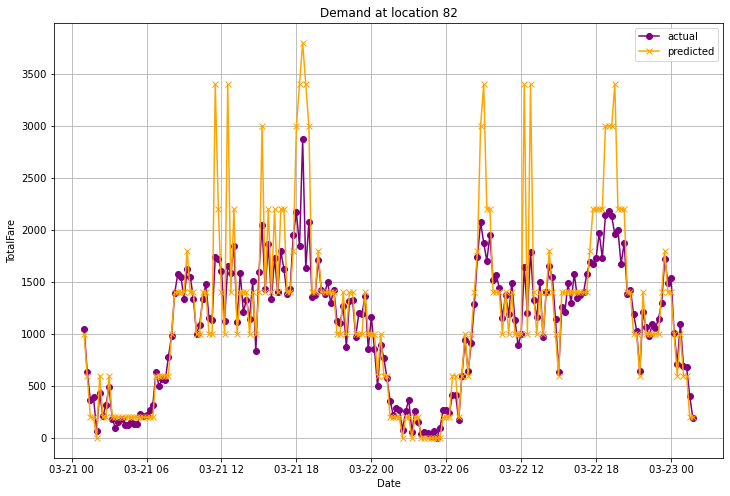

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_by_loc['test82'][4:200].index.values,
        test_by_loc['test82'][4:200].values,
        '-o',
        color='purple', label='actual')
ax.plot(test_by_loc['test82'][4:200].index.values,
        average_pred_82[:196],
        '-x',
        color='orange',label='predicted')

ax.set(xlabel="Date", ylabel="TotalFare",
       title="Demand at location 82")
plt.grid()
ax.legend()
# Format the x axis
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))

plt.show()

In [66]:
# fig, ax = plt.subplots()
# ax.plot(test_82_values)
# # ax.plot(test_by_loc['test82'][4:])
# ax.plot(average_pred_82)

# plt.xlabel('Date')
# plt.ylabel('TotalFare')

In [67]:
##loc 116
arr_train_116 = np.zeros(7584)
j=0
for (i,j) in zip (train_by_loc['train_116'],range(7584)):
    if (i>=100 and i<=407):
        arr_train_116[j]=1
    elif(i>=408 and i<=808):
        arr_train_116[j]=2
    elif(i>=809 and i<=1209):
        arr_train_116[j]=3
    elif(i>=1210 and i<=1610):
        arr_train_116[j]=4
    elif(i>=1611 and i<=2011):
        arr_train_116[j]=5
    elif(i>=2012 and i<2412):
        arr_train_116[j]=6
    elif(i>=2413 and i<=2813):
        arr_train_116[j]=7
    elif(i>=2814 and i<=3214):
        arr_train_116[j]=8
    elif(i>=3215 and i<3615):
        arr_train_116[j]=9
    elif(i>=3616):
        arr_train_116[j]=10

arr_train_116 = arr_train_116.astype(int)

In [68]:
arr_test_116 = np.zeros(1056)
j=0
for (i,j) in zip (test_by_loc['test116'],range(1056)):
    if (i>=100 and i<=407):
        arr_test_116[j]=1
    elif(i>=408 and i<=808):
        arr_test_116[j]=2
    elif(i>=809 and i<=1209):
        arr_test_116[j]=3
    elif(i>=1210 and i<=1610):
        arr_test_116[j]=4
    elif(i>=1611 and i<=2011):
        arr_test_116[j]=5
    elif(i>=2012 and i<2412):
        arr_test_116[j]=6
    elif(i>=2413 and i<=2813):
        arr_test_116[j]=7
    elif(i>=2814 and i<=3214):
        arr_test_116[j]=8
    elif(i>=3215 and i<3615):
        arr_test_116[j]=9
    elif(i>=3616):
        arr_test_116[j]=10

arr_test_116 = arr_test_116.astype(int)

In [69]:
train116=train_by_loc['train_116']
train116=arr_train_116

test116=test_by_loc['test116']
test116=arr_test_116

In [70]:
# 1 state transition probability matrix

q1_116 = state_transition_matrix(train116,1)
for row in q1_116: print(' '.join('{0:.2f}'.format(x) for x in row))

0.18 0.61 0.11 0.02 0.06 0.02 0.00 0.00 0.00 0.00 0.00
0.09 0.58 0.31 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.22 0.50 0.21 0.06 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.13 0.45 0.34 0.06 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.04 0.31 0.43 0.19 0.02 0.00 0.00 0.00 0.00
0.00 0.00 0.01 0.12 0.37 0.34 0.13 0.03 0.01 0.00 0.00
0.01 0.00 0.00 0.02 0.24 0.35 0.25 0.10 0.03 0.00 0.00
0.00 0.00 0.00 0.00 0.10 0.28 0.33 0.22 0.06 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.10 0.26 0.26 0.29 0.10 0.00
0.00 0.00 0.00 0.00 0.00 0.25 0.00 0.50 0.25 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00


In [71]:
q2_116 = state_transition_matrix(train116,2)
for row in q2_116: print(' '.join('{0:.2f}'.format(x) for x in row))

0.18 0.62 0.12 0.02 0.04 0.02 0.00 0.00 0.00 0.00 0.00
0.09 0.55 0.33 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.23 0.46 0.24 0.06 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.02 0.13 0.44 0.33 0.07 0.01 0.00 0.00 0.00 0.00
0.00 0.00 0.05 0.30 0.43 0.18 0.03 0.01 0.00 0.00 0.00
0.00 0.00 0.01 0.12 0.38 0.33 0.13 0.02 0.00 0.00 0.00
0.00 0.00 0.01 0.03 0.19 0.40 0.23 0.11 0.02 0.00 0.00
0.00 0.00 0.01 0.02 0.14 0.21 0.29 0.21 0.11 0.01 0.00
0.00 0.00 0.00 0.00 0.00 0.10 0.26 0.35 0.23 0.06 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.25 0.25 0.50 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00


In [72]:
q3_116 = state_transition_matrix(train116,3)
for row in q3_116: print(' '.join('{0:.2f}'.format(x) for x in row))

0.20 0.48 0.24 0.02 0.05 0.02 0.00 0.00 0.00 0.00 0.00
0.09 0.53 0.33 0.05 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.23 0.42 0.24 0.08 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.02 0.15 0.42 0.33 0.07 0.01 0.00 0.00 0.00 0.00
0.00 0.01 0.05 0.31 0.42 0.18 0.04 0.00 0.00 0.00 0.00
0.00 0.00 0.02 0.12 0.38 0.33 0.11 0.03 0.00 0.00 0.00
0.01 0.00 0.02 0.05 0.21 0.35 0.22 0.10 0.05 0.00 0.00
0.00 0.00 0.01 0.07 0.15 0.20 0.26 0.20 0.09 0.02 0.00
0.00 0.00 0.00 0.00 0.00 0.16 0.23 0.42 0.13 0.06 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.75 0.25 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00


In [73]:
q4_116 = state_transition_matrix(train116,4)
for row in q4_116: print(' '.join('{0:.2f}'.format(x) for x in row))

0.13 0.59 0.18 0.05 0.03 0.01 0.01 0.00 0.00 0.00 0.00
0.09 0.49 0.36 0.06 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.23 0.39 0.24 0.11 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.03 0.14 0.41 0.32 0.08 0.01 0.00 0.00 0.00 0.00
0.00 0.01 0.05 0.30 0.41 0.18 0.03 0.01 0.00 0.00 0.00
0.00 0.00 0.02 0.14 0.38 0.30 0.11 0.03 0.00 0.00 0.00
0.01 0.00 0.02 0.07 0.20 0.36 0.22 0.09 0.02 0.01 0.00
0.00 0.00 0.04 0.01 0.08 0.23 0.32 0.17 0.13 0.02 0.00
0.00 0.00 0.00 0.00 0.00 0.26 0.32 0.26 0.16 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.25 0.25 0.50 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00


In [74]:
q5_116 = state_transition_matrix(train116,5)
for row in q5_116: print(' '.join('{0:.2f}'.format(x) for x in row))

0.15 0.48 0.27 0.05 0.02 0.02 0.01 0.00 0.00 0.00 0.00
0.09 0.45 0.37 0.08 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.24 0.36 0.25 0.12 0.02 0.00 0.00 0.00 0.00 0.00
0.00 0.05 0.15 0.37 0.35 0.08 0.01 0.00 0.00 0.00 0.00
0.00 0.01 0.06 0.31 0.39 0.18 0.03 0.01 0.00 0.00 0.00
0.00 0.00 0.03 0.17 0.35 0.29 0.12 0.03 0.01 0.00 0.00
0.01 0.00 0.03 0.05 0.25 0.32 0.21 0.10 0.02 0.00 0.00
0.00 0.01 0.03 0.02 0.11 0.26 0.24 0.18 0.12 0.02 0.01
0.00 0.00 0.00 0.00 0.00 0.19 0.39 0.19 0.19 0.03 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00


In [75]:
lasthour116=test116[0:5]
print(len(lasthour116))
print(len(test116))
hidden_data116=test116[5:]
print(hidden_data116)

5
1056
[3 1 2 ... 4 3 1]


In [76]:
predicted_state_116  = np.zeros(1051)
for i in range (1051):
    lasthour116 = np.delete(lasthour116,0)
    lasthour116 = np.append(lasthour116,[hidden_data116[i]])
    states116 = np.zeros((5,11))
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []

    for j in range(5):
        states116[j][lasthour116[j]]=1
        
    x1 = states116[0]
    x1 = np.reshape(x1,(11,1))
    x2 = states116[1]
    x2 = np.reshape(x2,(11,1))
    x3 = states116[2]
    x3 = np.reshape(x3,(11,1))
    x4 = states116[3]
    x4 = np.reshape(x4,(11,1))
    x5 = states116[4]
    x5 = np.reshape(x5,(11,1))
   
    nextstate=[]
    nextstate = weights_116[0]*np.matmul(q1_116,x5)+weights_116[1]*np.matmul(q2_116,x4)+weights_116[2]*np.matmul(q3_116,x3)+weights_116[3]*np.matmul(q4_116,x2)+weights_116[4]*np.matmul(q5_116,x1)
    
    max1 = np.amax(nextstate)
    maxindex = np.argmax(nextstate)
    predicted_state_116[i] =  maxindex
    

In [77]:
predicted_state_116 = predicted_state_116.astype(int)
for i in range(1051):
    if(predicted_state_116[i]==0):
        predicted_state_116[i] = 0
    elif(predicted_state_116[i]==1):
        predicted_state_116[i]=200
    elif(predicted_state_116[i]==2):
        predicted_state_116[i]=600
    elif(predicted_state_116[i]==3):
        predicted_state_116[i]=1000
    elif(predicted_state_116[i]==4):
        predicted_state_116[i]=1400
    elif(predicted_state_116[i]==5):
        predicted_state_116[i]=1800
    elif(predicted_state_116[i]==6):
        predicted_state_116[i]=2200
    elif(predicted_state_116[i]==7):
        predicted_state_116[i]=2600
    elif(predicted_state_116[i]==8):
        predicted_state_116[i]=3000
    elif(predicted_state_116[i]==9):
        predicted_state_116[i]=3400
    elif(predicted_state_116[i]==10):
        predicted_state_116[i]=3800
    elif(predicted_state_116[i]==11):
        predicted_state_116[i]=4000
    
print(predicted_state_116)

[1000    0  600 ... 1400 1000    0]


In [78]:
predicted_state_116.shape

(1051,)

In [79]:
test_116_values=test_by_loc['test116'].values[5:]
test_116_values
# a=np.sum(test_116_values-predicted_state_116)/1051
a=0
average_pred_116 = np.zeros(1051)
average_pred_116=predicted_state_116
for i in range(1051):
    average_pred_116[i]+=(a)
error_116=sqrt(mean_squared_error(test_116_values,average_pred_116))
print(error_116)

559.4609928826842


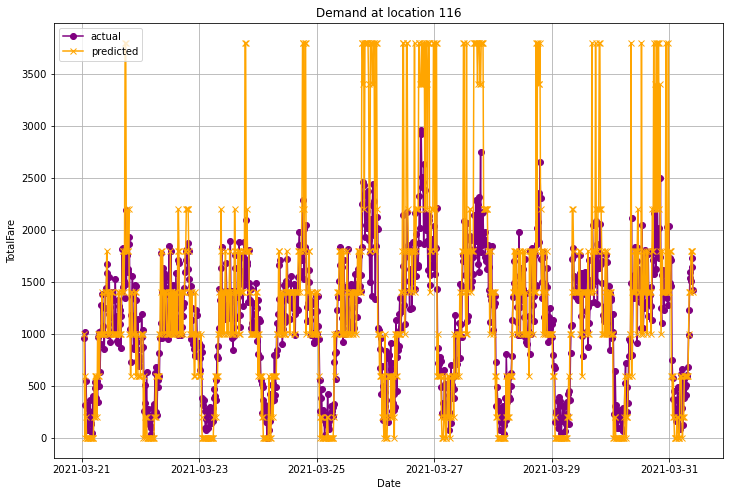

In [80]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_by_loc['test116'][4:1000].index.values,
        test_by_loc['test116'][4:1000].values,
        '-o',
        color='purple', label="actual")
ax.plot(test_by_loc['test116'][4:1000].index.values,
        average_pred_116[:996],
        '-x',
        color='orange',label="predicted")

ax.set(xlabel="Date", ylabel="TotalFare",
       title="Demand at location 116")
ax.legend()
plt.grid()


plt.show()

In [81]:
##loc 111
arr_train_111 = np.zeros(7584)
j=0
for (i,j) in zip (train_by_loc['train_111'],range(7584)):
    if (i>=50 and i<=107):
        arr_train_111[j]=1
    elif(i>=108 and i<=208):
        arr_train_111[j]=2
    elif(i>=209 and i<=309):
        arr_train_111[j]=3
    elif(i>=310 and i<=410):
        arr_train_111[j]=4
    elif(i>=411 and i<=511):
        arr_train_111[j]=5
    elif(i>=512 and i<612):
        arr_train_111[j]=6
    elif(i>=613 and i<=713):
        arr_train_111[j]=7
    elif(i>=714 and i<=814):
        arr_train_111[j]=8
    elif(i>=815 and i<915):
        arr_train_111[j]=9
    elif(i>=916):
        arr_train_111[j]=10

arr_train_111 = arr_train_111.astype(int)

In [82]:
arr_test_111 = np.zeros(1056)
j=0
for (i,j) in zip (test_by_loc['test111'],range(1056)):
    if (i>=50 and i<=107):
        arr_test_111[j]=1
    elif(i>=108 and i<=208):
        arr_test_111[j]=2
    elif(i>=209 and i<=309):
        arr_test_111[j]=3
    elif(i>=310 and i<=410):
        arr_test_111[j]=4
    elif(i>=411 and i<=511):
        arr_test_111[j]=5
    elif(i>=512 and i<612):
        arr_test_111[j]=6
    elif(i>=613 and i<=713):
        arr_test_111[j]=7
    elif(i>=714 and i<=814):
        arr_test_111[j]=8
    elif(i>=815 and i<915):
        arr_test_111[j]=9
    elif(i>=916):
        arr_test_111[j]=10

arr_test_111 = arr_test_111.astype(int)

In [83]:
train111=train_by_loc['train_111']
train111=arr_train_111

test111=test_by_loc['test111']
test111=arr_test_111

In [84]:
# 1 state transition probability matrix

q1_111 = state_transition_matrix(train111,1)
for row in q1_111: print(' '.join('{0:.2f}'.format(x) for x in row))
    
# 2 state transition probability matrix

q2_111 = state_transition_matrix(train111,2)
# for row in q2_111: print(' '.join('{0:.2f}'.format(x) for x in row))
    
q3_111 = state_transition_matrix(train111,3)
# for row in q3_111: print(' '.join('{0:.2f}'.format(x) for x in row))

q4_111 = state_transition_matrix(train111,4)
# for row in q4_111: print(' '.join('{0:.2f}'.format(x) for x in row))
    
q5_111 = state_transition_matrix(train111,5)
# for row in q5_111: print(' '.join('{0:.2f}'.format(x) for x in row))

0.18 0.28 0.29 0.11 0.07 0.03 0.01 0.03 0.00 0.00 0.01
0.18 0.24 0.32 0.17 0.06 0.02 0.01 0.00 0.00 0.00 0.00
0.10 0.15 0.32 0.22 0.11 0.07 0.02 0.01 0.00 0.00 0.00
0.03 0.06 0.20 0.21 0.20 0.15 0.08 0.05 0.02 0.00 0.00
0.02 0.02 0.10 0.19 0.23 0.20 0.13 0.07 0.04 0.01 0.00
0.01 0.01 0.06 0.12 0.21 0.22 0.17 0.11 0.05 0.02 0.01
0.01 0.00 0.02 0.10 0.17 0.22 0.21 0.13 0.06 0.04 0.02
0.00 0.00 0.02 0.08 0.19 0.24 0.22 0.13 0.08 0.03 0.01
0.01 0.00 0.01 0.05 0.13 0.22 0.23 0.14 0.11 0.04 0.04
0.02 0.00 0.01 0.04 0.10 0.23 0.16 0.22 0.10 0.05 0.09
0.00 0.00 0.00 0.03 0.11 0.17 0.21 0.11 0.15 0.17 0.04


In [85]:
lasthour111=test111[0:5]
print(len(test111))
hidden_data111=test111[5:]
print(hidden_data111)

1056
[1 1 2 ... 3 2 0]


In [86]:
predicted_state_111  = np.zeros(1051)
for i in range (1051):
    lasthour111 = np.delete(lasthour111,0)
    lasthour111 = np.append(lasthour111,[hidden_data111[i]])
    states111 = np.zeros((5,11))
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []

    for j in range(4):
        states111[j][lasthour111[j]]=1
        
    x1 = states111[0]
    x1 = np.reshape(x1,(11,1))
    x2 = states111[1]
    x2 = np.reshape(x2,(11,1))
    x3 = states111[2]
    x3 = np.reshape(x3,(11,1))
    x4 = states111[3]
    x4 = np.reshape(x4,(11,1))
    x5 = states111[4]

    nextstate = []
    nextstate = weights_111[0]*np.matmul(q1_111,x5)+weights_111[1]*np.matmul(q2_111,x4)+weights_111[2]*np.matmul(q3_111,x3)+weights_111[3]*np.matmul(q4_111,x2)+weights_111[4]*np.matmul(q5_111,x1)
    
    max1 = np.amax(nextstate)
    maxindex = np.argmax(nextstate)
    predicted_state_111[i] =  maxindex
    

In [87]:
predicted_state_111 = predicted_state_111.astype(int)
for i in range(1051):
    if(predicted_state_111[i]==0):
        predicted_state_111[i] = 0
    elif(predicted_state_111[i]==1):
        predicted_state_111[i]=50
    elif(predicted_state_111[i]==2):
        predicted_state_111[i]=150
    elif(predicted_state_111[i]==3):
        predicted_state_111[i]=250
    elif(predicted_state_111[i]==4):
        predicted_state_111[i]=350
    elif(predicted_state_111[i]==5):
        predicted_state_111[i]=450
    elif(predicted_state_111[i]==6):
        predicted_state_111[i]=550
    elif(predicted_state_111[i]==7):
        predicted_state_111[i]=650
    elif(predicted_state_111[i]==8):
        predicted_state_111[i]=750
    elif(predicted_state_111[i]==9):
        predicted_state_111[i]=850
    elif(predicted_state_111[i]==10):
        predicted_state_111[i]=950
    elif(predicted_state_111[i]==11):
        predicted_state_111[i]=1050
    
print(predicted_state_111)

[22 22  0 ... 22 22 22]


In [88]:
test_111_values=test_by_loc['test111'].values[5:]
test_111_values
a=np.sum(test_111_values-predicted_state_111)/1051
average_pred_111 = np.zeros(1051)
average_pred_111=predicted_state_111
for i in range(1051):
    average_pred_111[i]+=(a)

from sklearn.metrics import mean_squared_error
from math import sqrt
error_111=sqrt(mean_squared_error(np.array(test_111_values),np.array(average_pred_111)))
print(error_111)

525.5013008827816


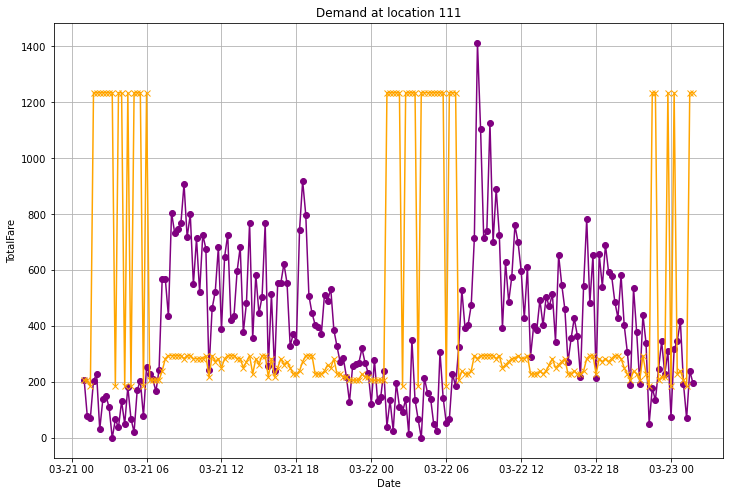

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_by_loc['test111'][4:200].index.values,
        test_by_loc['test111'][4:200].values,
        '-o',
        color='purple')
ax.plot(test_by_loc['test111'][4:200].index.values,
        average_pred_111[:196],
        '-x',
        color='orange')

ax.set(xlabel="Date", ylabel="TotalFare",
       title="Demand at location 111")
plt.grid()
plt.show()

In [90]:
##loc 11
arr_train_11 = np.zeros(7584)
j=0
for (i,j) in zip (train_by_loc['train_11'],range(7584)):
    if (i>=50 and i<=107):
        arr_train_11[j]=1
    elif(i>=108 and i<=208):
        arr_train_11[j]=2
    elif(i>=209 and i<=309):
        arr_train_11[j]=3
    elif(i>=310 and i<=410):
        arr_train_11[j]=4
    elif(i>=411 and i<=511):
        arr_train_11[j]=5
    elif(i>=512 and i<612):
        arr_train_11[j]=6
    elif(i>=613 and i<=713):
        arr_train_11[j]=7
    elif(i>=714 and i<=814):
        arr_train_11[j]=8
    elif(i>=815 and i<915):
        arr_train_11[j]=9
    elif(i>=916):
        arr_train_11[j]=10

arr_train_11 = arr_train_11.astype(int)

In [91]:
arr_test_11 = np.zeros(1056)
j=0
for (i,j) in zip (test_by_loc['test11'],range(1056)):
    if (i>=50 and i<=107):
        arr_test_11[j]=1
    elif(i>=108 and i<=208):
        arr_test_11[j]=2
    elif(i>=209 and i<=309):
        arr_test_11[j]=3
    elif(i>=310 and i<=410):
        arr_test_11[j]=4
    elif(i>=411 and i<=511):
        arr_test_11[j]=5
    elif(i>=512 and i<612):
        arr_test_11[j]=6
    elif(i>=613 and i<=713):
        arr_test_11[j]=7
    elif(i>=714 and i<=814):
        arr_test_11[j]=8
    elif(i>=815 and i<915):
        arr_test_11[j]=9
    elif(i>=916):
        arr_test_11[j]=10

arr_test_11 = arr_test_11.astype(int)

In [92]:
train11=train_by_loc['train_11']
train11=arr_train_11

test11=test_by_loc['test11']
test11=arr_test_11

In [93]:
# 1 state transition probability matrix

q1_11 = state_transition_matrix(train11,1)
for row in q1_11: print(' '.join('{0:.2f}'.format(x) for x in row))
    
# 2 state transition probability matrix

q2_11 = state_transition_matrix(train11,2)
# for row in q2_11: print(' '.join('{0:.2f}'.format(x) for x in row))
    
q3_11 = state_transition_matrix(train11,3)
# for row in q3_11: print(' '.join('{0:.2f}'.format(x) for x in row))

q4_11 = state_transition_matrix(train11,4)
# for row in q4_11: print(' '.join('{0:.2f}'.format(x) for x in row))
    
q5_11 = state_transition_matrix(train11,5)
# for row in q5_11: print(' '.join('{0:.2f}'.format(x) for x in row))

0.51 0.32 0.11 0.02 0.01 0.02 0.00 0.01 0.00 0.00 0.00
0.36 0.34 0.22 0.06 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.11 0.20 0.36 0.19 0.10 0.03 0.01 0.01 0.00 0.00 0.00
0.02 0.04 0.17 0.26 0.23 0.15 0.10 0.03 0.01 0.00 0.00
0.01 0.01 0.06 0.18 0.26 0.24 0.16 0.06 0.03 0.01 0.00
0.01 0.00 0.02 0.10 0.22 0.23 0.18 0.14 0.06 0.02 0.01
0.01 0.00 0.01 0.06 0.14 0.27 0.24 0.14 0.08 0.03 0.01
0.00 0.00 0.00 0.04 0.11 0.23 0.23 0.21 0.11 0.04 0.02
0.01 0.00 0.00 0.02 0.12 0.17 0.21 0.22 0.14 0.07 0.04
0.00 0.00 0.00 0.01 0.06 0.16 0.23 0.21 0.14 0.14 0.06
0.03 0.00 0.00 0.04 0.03 0.08 0.20 0.23 0.15 0.10 0.14


In [94]:
lasthour11=test11[0:5]
print(len(test11))
hidden_data11=test11[5:]
print(hidden_data11)

1056
[2 1 3 ... 7 3 1]


In [95]:
predicted_state_11  = np.zeros(1051)
for i in range (1051):
    lasthour11 = np.delete(lasthour11,0)
    lasthour11 = np.append(lasthour11,[hidden_data11[i]])
    states11 = np.zeros((5,11))
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []

    for j in range(4):
        states11[j][lasthour11[j]]=1
        
    x1 = states11[0]
    x1 = np.reshape(x1,(11,1))
    x2 = states11[1]
    x2 = np.reshape(x2,(11,1))
    x3 = states11[2]
    x3 = np.reshape(x3,(11,1))
    x4 = states11[3]
    x4 = np.reshape(x4,(11,1))
    x5 = states11[4]

    nextstate = []
    nextstate = weights_11[0]*np.matmul(q1_11,x5)+weights_11[1]*np.matmul(q2_11,x4)+weights_11[2]*np.matmul(q3_11,x3)+weights_11[3]*np.matmul(q4_11,x2)+weights_11[4]*np.matmul(q5_11,x1)
    
    max1 = np.amax(nextstate)
    maxindex = np.argmax(nextstate)
    predicted_state_11[i] =  maxindex
    

In [96]:
predicted_state_11 = predicted_state_11.astype(int)
for i in range(1051):
    if(predicted_state_11[i]==0):
        predicted_state_11[i] = 0
    elif(predicted_state_11[i]==1):
        predicted_state_11[i]=50
    elif(predicted_state_11[i]==2):
        predicted_state_11[i]=150
    elif(predicted_state_11[i]==3):
        predicted_state_11[i]=250
    elif(predicted_state_11[i]==4):
        predicted_state_11[i]=350
    elif(predicted_state_11[i]==5):
        predicted_state_11[i]=450
    elif(predicted_state_11[i]==6):
        predicted_state_11[i]=550
    elif(predicted_state_11[i]==7):
        predicted_state_11[i]=650
    elif(predicted_state_11[i]==8):
        predicted_state_11[i]=750
    elif(predicted_state_11[i]==9):
        predicted_state_11[i]=850
    elif(predicted_state_11[i]==10):
        predicted_state_11[i]=950
    elif(predicted_state_11[i]==11):
        predicted_state_11[i]=1050
    
print(predicted_state_11)

[  22   22 1050 ...  110   88  110]


In [97]:
test_11_values=test_by_loc['test11'].values[5:]
test_11_values
# a=np.sum(test_11_values-predicted_state_11)/1051
a=0
average_pred_11 = np.zeros(1051)
average_pred_11=predicted_state_11
for i in range(1051):
    average_pred_11[i]+=(a)

error_11=sqrt(mean_squared_error(np.array(test_11_values),np.array(average_pred_11)))
print(error_11)

428.39812291936727


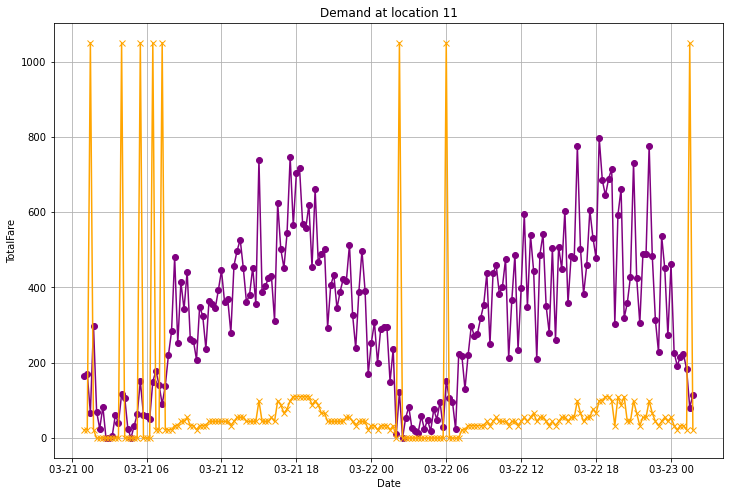

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_by_loc['test11'][4:200].index.values,
        test_by_loc['test11'][4:200].values,
        '-o',
        color='purple')
ax.plot(test_by_loc['test11'][4:200].index.values,
        average_pred_11[:196],
        '-x',
        color='orange')

ax.set(xlabel="Date", ylabel="TotalFare",
       title="Demand at location 11")
plt.grid()
plt.show()